In [ ]:
## I am going to implement micrograd from Karpathy's famous YouTube video: 


Autograd Engine.

Implements Backprop.

Backprop allows you to effenciently eval the gradient of a loss function with respect to the weights of a NN.

We can iteratively tune the weights of the NN to minimise the loss function and improve the accuracy of the network.

It is at the code of PyTorch / JAX



We wrap the scaler values around a `Value` object.

In [1]:
import numpy as np


```
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass

g.backward() # will initialise backprop @ the node g.

print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db
```

`Value` will wrap the numbers. 

- add
- multiply
- raise to a power
- offset by one
- negate
- squash
- divide
- divide by a value


It will build out the entire mathematical graph and it will know where `g` came from.

Backprop will go backwards through the expression graph and apply chain rule recursively.

We can query `dg/da` --> a.grad --> How `a` and `b` effects `g` through the mathematical expression. So, `a.grad` is 138, if we slightly nudge a in the positive direction, then the slope of growth of `g` will be 138.

Tensors and Arrays are just done for efficiency reasons. None of the math changes when we shift from Scalers to Tensors. So there's no point of using Tensors from Scratch


**Claim**: Micrograd is all you need to train NNs. Everything else is just efficiency.

## What is a Derivitve (intuition)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


$f(x) = 3x^2 - 4x + 5$

$f'(x) = 6x - 4$

In [3]:
def f(x):
    return 3*x**2 - 4*x +5


In [4]:
f(3.0)


20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


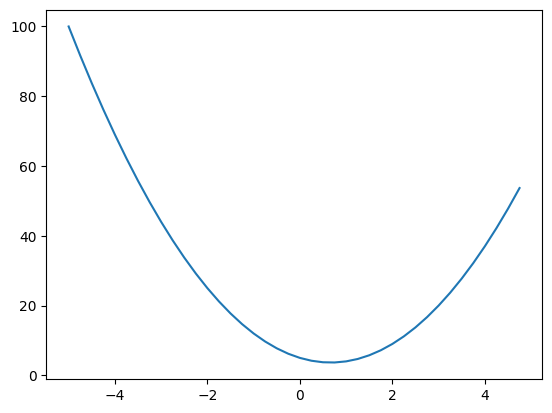

In [5]:
xs = np.arange(-5, 5, 0.25)
print(xs)
ys = f(xs)

plt.plot(xs, ys)


No one does the derivative mathematically. Let's understand the definition of the derivative and what it actually tells you

If you slightly increase the x by a small number h, with what sensitivity does the function respond? What is the slope at that point? Does it go up or does it go down? It's the slope of that response at that time

In [6]:
f(3.0)


20.0

In [7]:
h = 0.000000000001
x = 3.0

# slope - >
( f(x+h) - f(x) ) / h


14.001244608152774

In [8]:
h = 0.000000000001
x = -3.0

# slope - >
( f(x+h) - f(x) ) / h


-21.9984030991327

In [9]:
h = 0.000000000001
x = 2/3

# slope - >
( f(x+h) - f(x) ) / h


-0.0004440892098500626

### Now let's make it a bit more complex

In [10]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)


4.0


Bumping a

In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # how much the function increased when we bumped the input we are interested in by 
                            # a tiny amount


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


Bumping b

In [12]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # how much the function increased when we bumped the input we are interested in by 
                            # a tiny amount


d1 4.0
d2 4.0002
slope 2.0000000000042206


Bumping c

In [13]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # how much the function increased when we bumped the input we are interested in by 
                            # a tiny amount


d1 4.0
d2 4.0001
slope 0.9999999999976694


### Let's move to NN

Let's build out the value object

In [14]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3)
c = Value(10.0)
# a+b ==> a.__add__(b)
# a*b ==> a.__mul__(b)

# a * b + c  -> (a.__mul__(b)).__add__(c)

# a * b + c
# (a.__mul__(b)).__add__(c)

d = a*b + c
d


Value(data=4.0)

We have to tell Python how to add two Value objects

Now we are missing the connective tissue of this expression. We want expression graphs, so we need to maintain points as to what values led to other values


In [15]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label # passed as input

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")
        return out

a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10.0, label='c')   

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
print(L)

print(d._prev, d._op)
print(e._prev, e._op)


Value(data=-8.0)
{Value(data=10.0), Value(data=-6.0)} +
{Value(data=-3), Value(data=2.0)} *


How to visualise

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


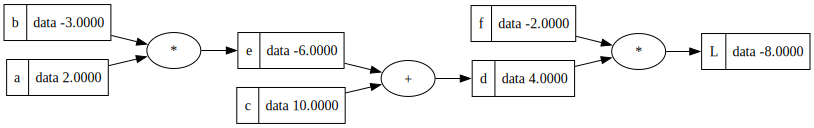

In [17]:
draw_dot(L)


So now we are interested in the derivative of the output with respect to some of it's leaf nodes.


So now we have to create a variable inside the value class that maintains the derivative of L wrt to that Value.


In [18]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')   

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
print(f"The final value of L: {L.data}")

print(f"d._prev: {d._prev}, d._op: {d._op}")
print(f"e._prev: {e._prev}, e._op: {e._op}")


The final value of L: -8.0
d._prev: {Value(data=-6.0), Value(data=10.0)}, d._op: +
e._prev: {Value(data=-3.0), Value(data=2.0)}, e._op: *


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


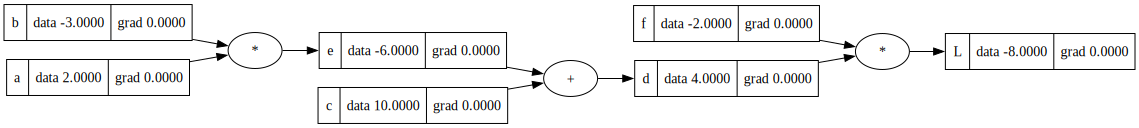

In [20]:
draw_dot(L)


Now we are ready to fill in the gradients!

In [21]:
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    L2 = L.data + h

    print((L2-L1)/h)

verify_derivatives_numerically()


1.000000000000334


So it's obvious that the gradient of L will be 1

Let's do backprop manually


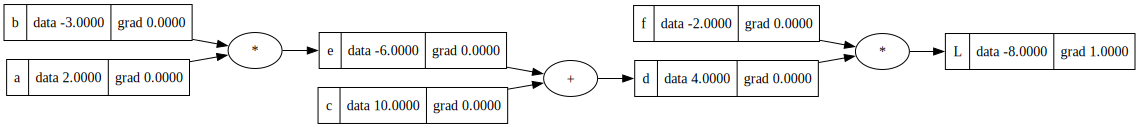

In [22]:
L.grad = 1.0

draw_dot(L)


Now let's figure out the grad of d now.

So now we need to figure out $\frac{dL}{dd}$


Given,

$L = d * f$

$\frac{dL}{dd}$ = f (from calculus)



Now let's derive it:


$\frac{f(x+h) - f(x)}{h}$

$ \frac{(d+h)*f - d*f}{h}$ => $ \frac{df + fh - df}{h}$ => $ \frac{fh}{h}$ ==> f


### Derivative of $L$ with respect to $d$

Given:  
$
L = d \cdot f
$

By basic calculus:
$
\frac{dL}{dd} = f
$

---

Now, let's derive it using the definition of a derivative:

$
\frac{dL}{dd} = \lim_{h \to 0} \frac{L(d + h) - L(d)}{h}
$

Substitute $L = d \cdot f$ (assuming $f$ is constant with respect to $d$):

$
= \lim_{h \to 0} \frac{(d + h) \cdot f - d \cdot f}{h}
$

$
= \lim_{h \to 0} \frac{df + hf - df}{h}
$

$
= \lim_{h \to 0} \frac{hf}{h}
$

$
= \lim_{h \to 0} f = f
$



In [23]:
# So

d.grad = f.data # -2
f.grad = d.data # 4


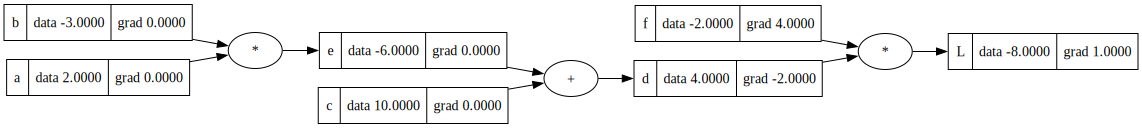

In [24]:
draw_dot(L)


In [25]:
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'

    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'

    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


3.9999999999995595


So, dL/df = 4 (which is the value of d)


In [26]:
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


-2.000000000000668


So we added a little h to d and see how L changes, to get $dL/dd = -2$


We now want to derive the gradient of L with respect to c


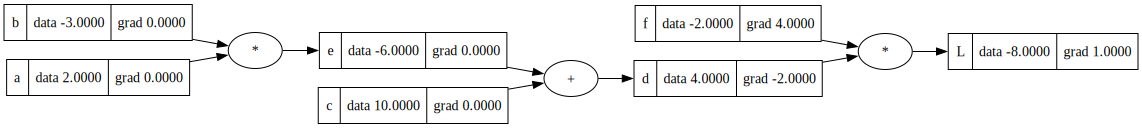

In [27]:
draw_dot(L)


Let's calculate dd/dc


dd/dc ? --> 1.0

d = c + e


Back to basics:

dd/dc = ?

d = c + e

(f(x+h) - f(x))/h

((c+h + e) - (c + e))/h

(h/h) -> 1 


So by symmetry dd/de = 1


So the local derivative is 1. The local plus node does not know anything about the rest of the graph...

The local graph knows dd/de and dd/dc...


So we know how d impacts L and how c&e impact d.

So we want

WANT:
dL/dc = (dL/dd) * (dd/dc)

KNOW:
- dL/dd
- dd/dc


But the derivative of dd/dc is 1 as it's a plus node, so it just routes the gradient dL/dd to both c and e nodes.

In [ ]:
c.grad = -2.0 * 1
e.grad = -2.0 * 1


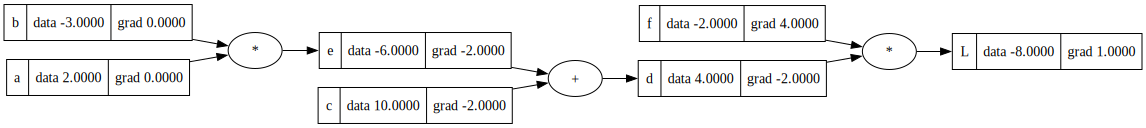

In [29]:
draw_dot(L)


In [30]:
# Verify dL/dc
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0+h, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


-1.9999999999988916


In [31]:
# Verify dL/de
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


-2.000000000000668


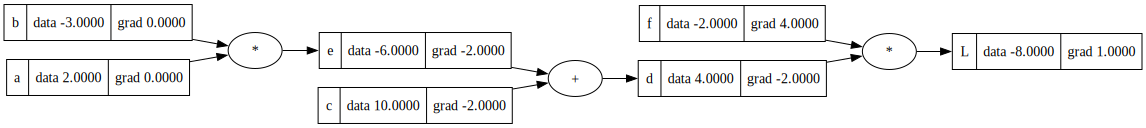

In [32]:
draw_dot(L)


So, we know dL/de = -2;

We want $\frac{dL}{da} = \frac{de}{da} \cdot \frac{dd}{de} \cdot \frac{dL}{dd}$ 


or 

e = a*b

de/da ? -> b


dL/da = (dL/de) * (de/da)


In [ ]:
# So

a.grad = -2.0 * -3
b.grad = -2.0 * 2.0


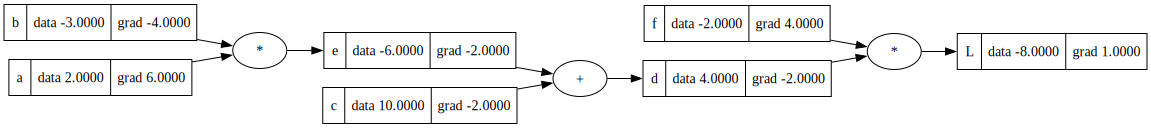

In [34]:
draw_dot(L)


In [35]:
# Verify dL/da
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


6.000000000000227


In [36]:
# Verify dL/db
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print(round((L2-L1)/h, 3))

verify_derivatives_numerically()


-4.0


So now let's try to increase the value of L based on our knowledge of the gradient.


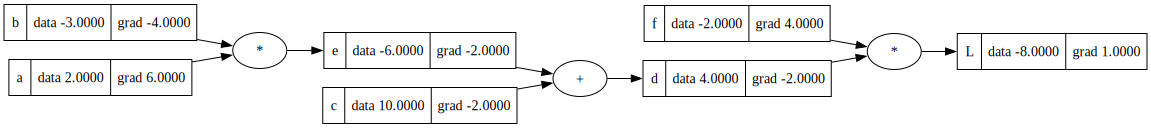

In [37]:
draw_dot(L)


In [38]:
# Leaf nodes which we usually have control over.

# If we nudge in the direction of the gradient, we expect a positive
# influence on L. 

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f

print(L.data)


-7.286496


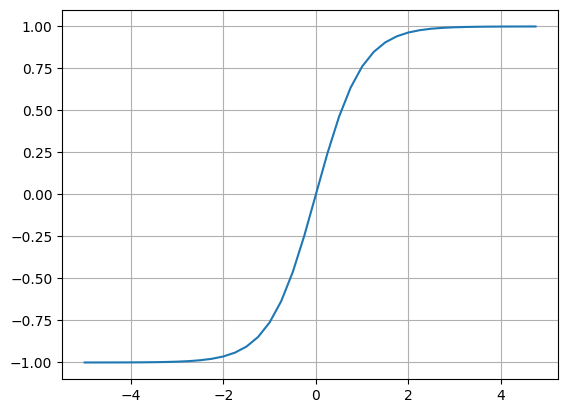

In [39]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25))); plt.grid();


<img src="./image.png" width="40%">


In [40]:


# inputs
x1 = Value(2.0, label='x1')
x2 = Value(2.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.7, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


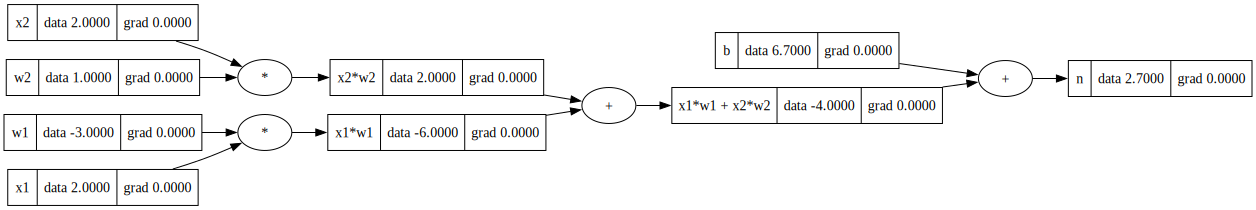

In [41]:
draw_dot(n)


So now we need to implement tanh in our value class.

1. Use exp and then build it from there
2. Cluster up and implement tanh directly


The only thing that matters is that we know how to differentiate tanh
and understand how it is impacting the output when some input goes through
it.


In [42]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out


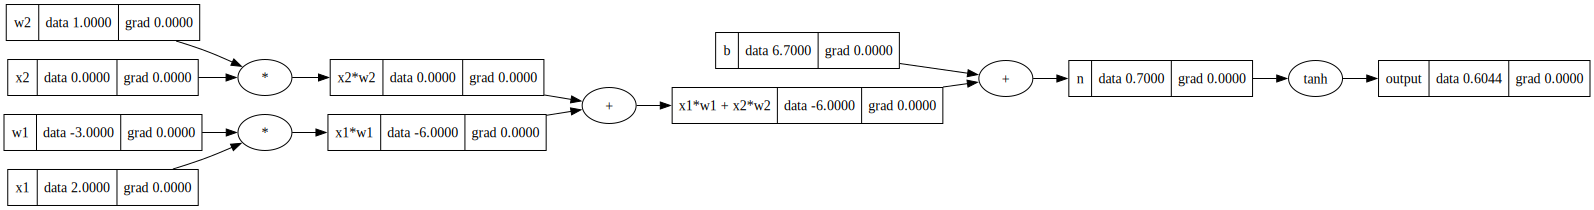

In [43]:


# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.7, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"
draw_dot(output)


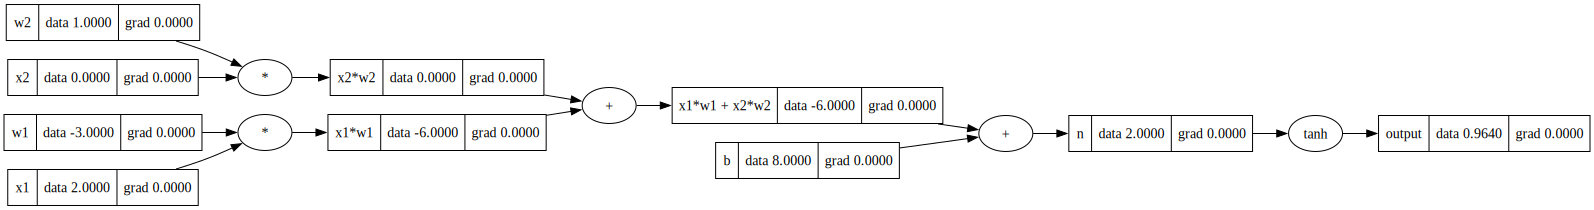

In [44]:
# To see the squashing nature of tanh active.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(8, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"
draw_dot(output)


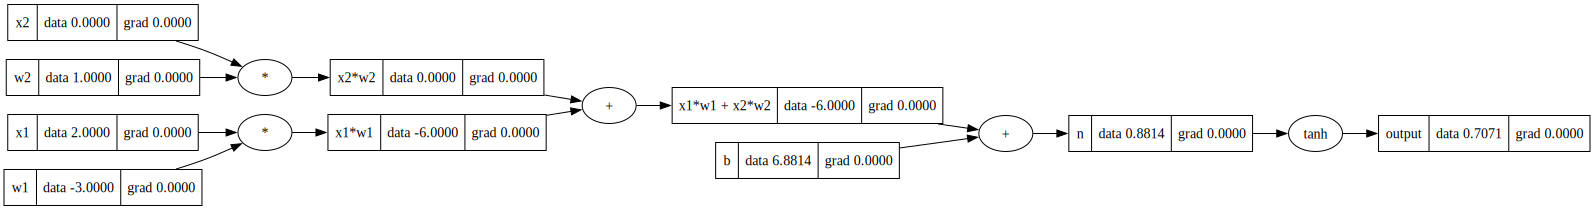

In [45]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"
draw_dot(output)


Let's start off backprop!

Remember this is just one node. In a NN there are multiple nodes and then there's a loss function as well


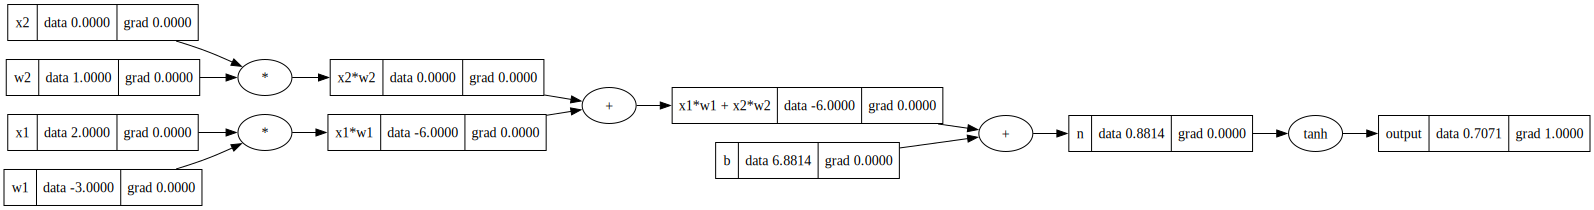

In [46]:
output.grad = 1.0
draw_dot(output)


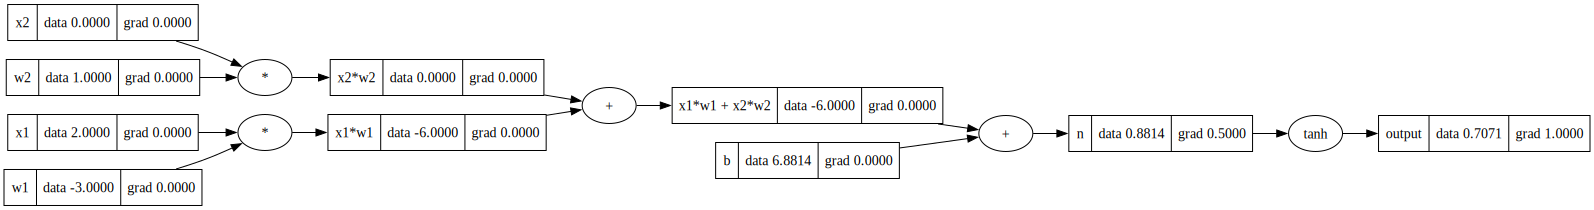

In [47]:
# o = tanh(n)
# what is do/dn ?

# do/dn = 1 - (tanh(n))**2
# do/dn = 1 - (o)**2

# so

n.grad = round(1 - output.data**2, 4) ## 0.5
draw_dot(output)


n = b + x1*w1+x2*w2

dn/db -> 1

dn/d(x1*w1+x2*w2) -->

So we want

do/db = do/dn * dn/db --> 0.5 * 1


In [48]:
# So

x1w1x2w2.grad=0.5
b.grad = 0.5


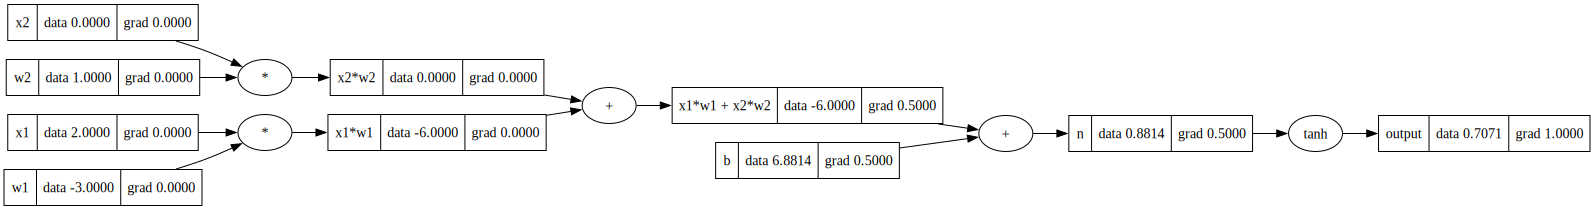

In [49]:
draw_dot(output)


In [50]:
x1w1.grad=0.5
x2w2.grad = 0.5


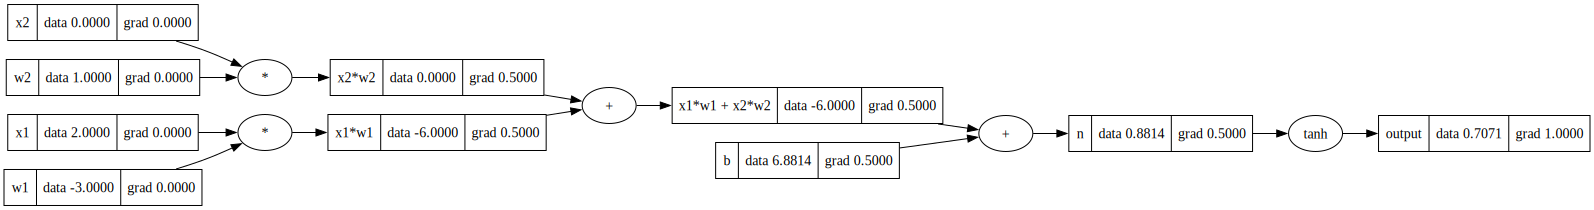

In [51]:
draw_dot(output)


Now let's calculate the grad for x2 and w2.


In [52]:
# Check notes on iPad for it to make sense


In [53]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


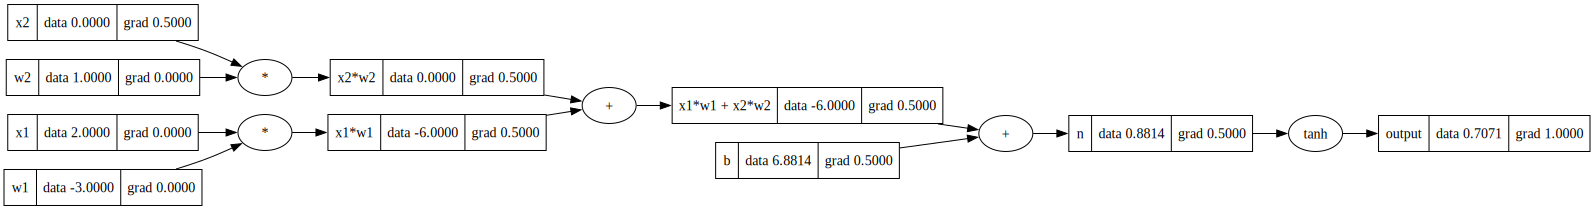

In [54]:
draw_dot(output)


w2's grad is 0 because of the way the numtiplication operations works.


If I wiggle w2, the output does not change at all, so the derivitve which tells us the effect that w2 has on the output also reports the same i.e. 0


In [55]:
x1.grad = w1.data * x1w1.grad # (x1*w1 = x1w1   dx1w1/dx1 = w1)
w1.grad = x1.data * x1w1.grad # (x1*w1 = x1w1   dx1w1/dw1 = x1)


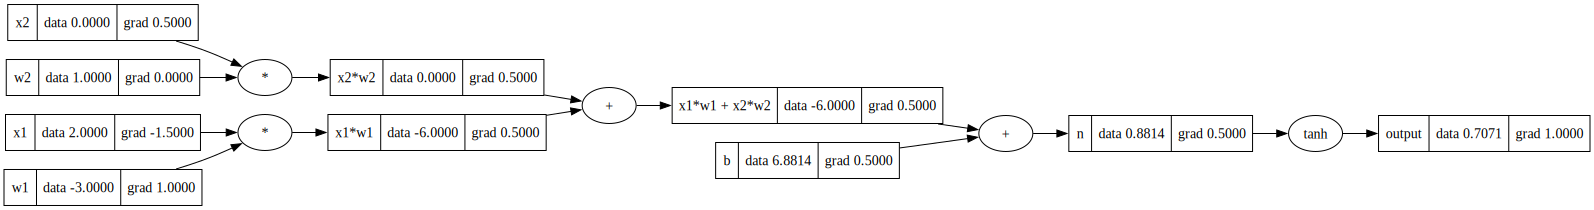

In [56]:
draw_dot(output)


#### So now let's codify the manual process we've been doing

In [57]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out


Value class redefined.


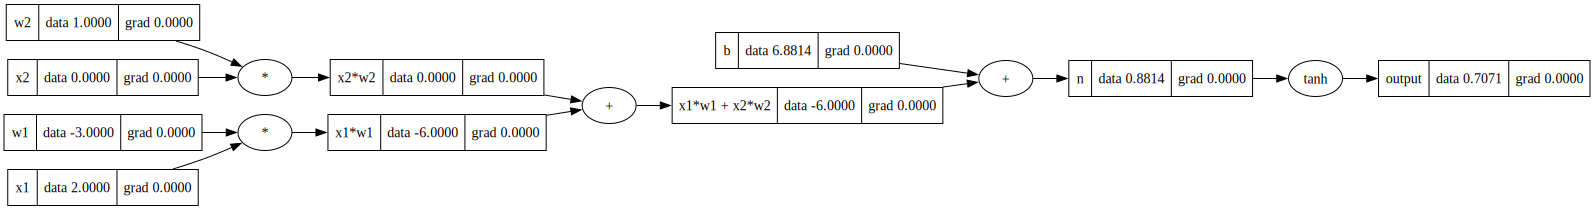

In [74]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"

draw_dot(output)


In [75]:
output.grad = 1


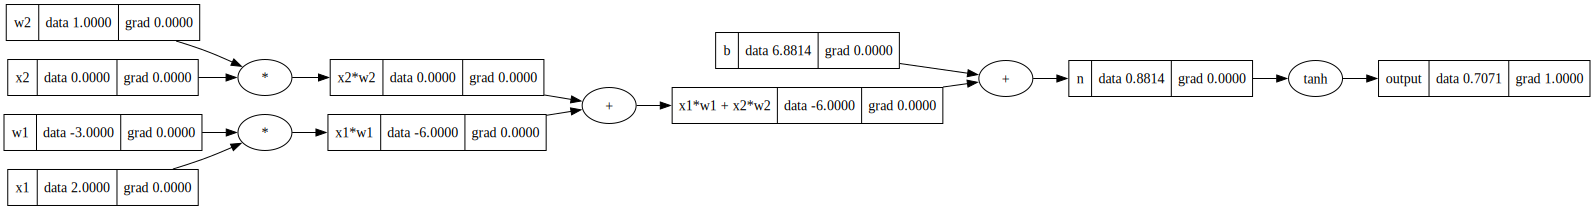

In [76]:
draw_dot(output)


In [77]:
output._backward()


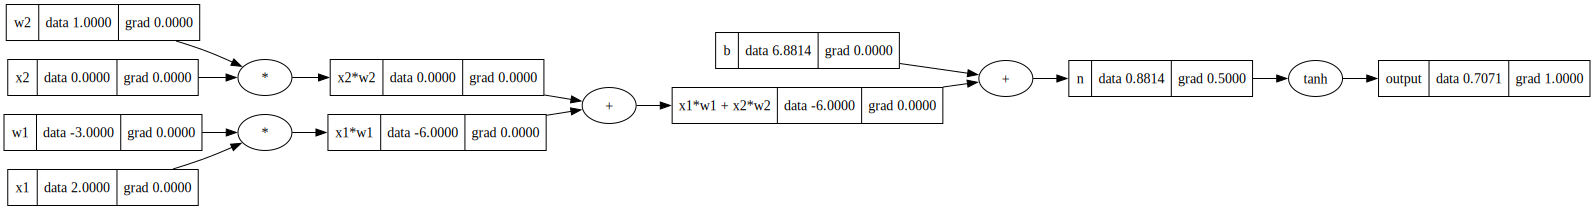

In [78]:
draw_dot(output)


In [79]:
n._backward()


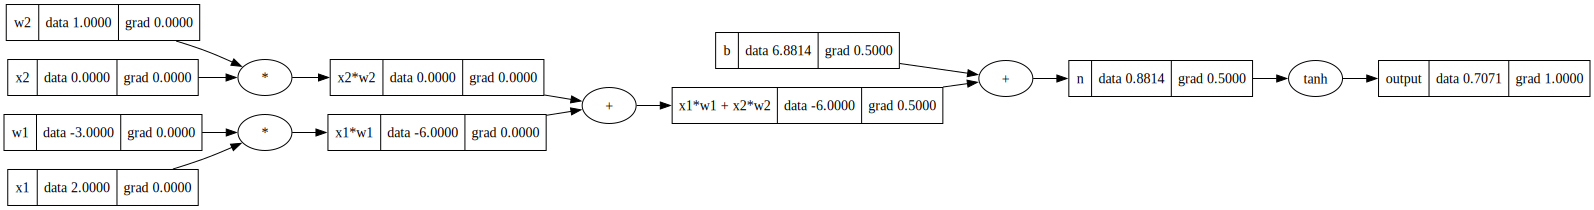

In [80]:
draw_dot(output)


#### lol b, does not even have a backward because it is a leaf node.


In [81]:
b._backward()


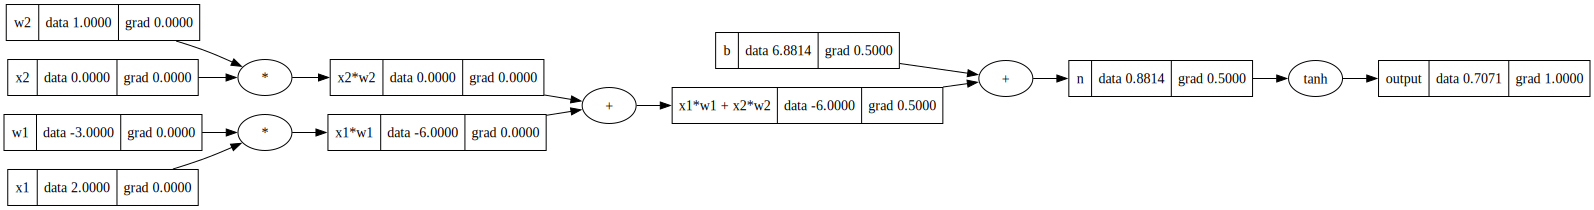

In [82]:
draw_dot(output)


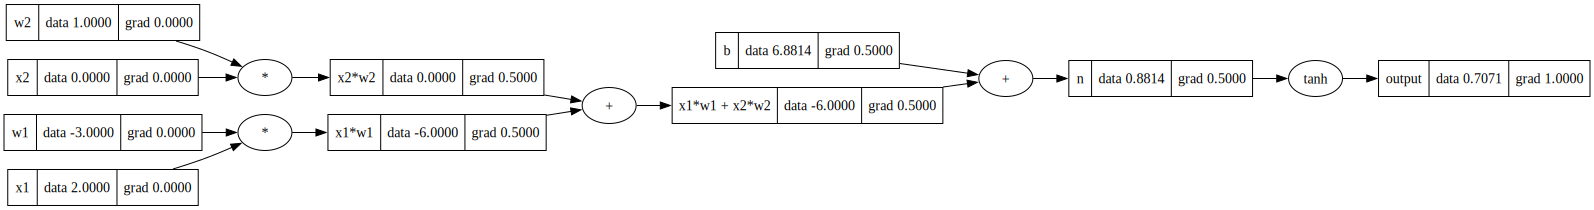

In [83]:
x1w1x2w2._backward()
draw_dot(output)


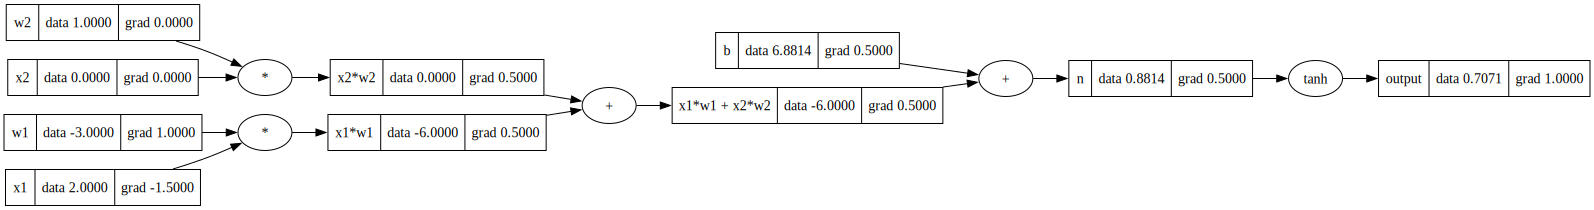

In [84]:
x1w1._backward()
draw_dot(output)



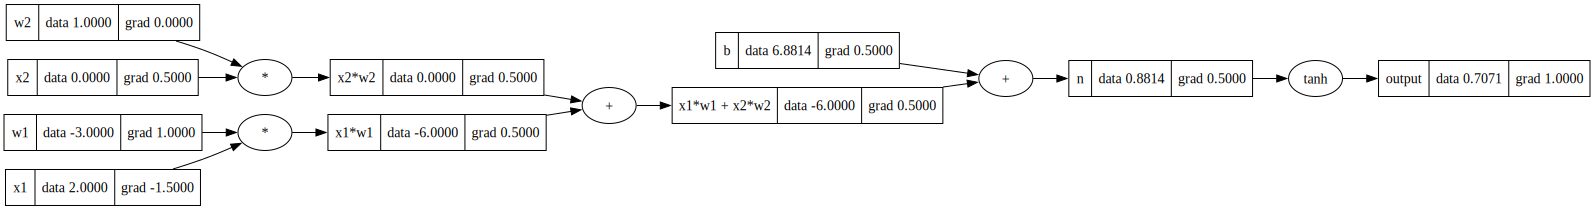

In [85]:
x2w2._backward()
draw_dot(output)


We need to now automate this and prevent us calling backward manually.


We never want to call a ._backward for any node before we've done everything after it. We need to get everything of its dependencies before we can call ._backward


To achieve this ordering of graphs, we can do topological sort.

In [86]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)

        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(output)
topo


[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

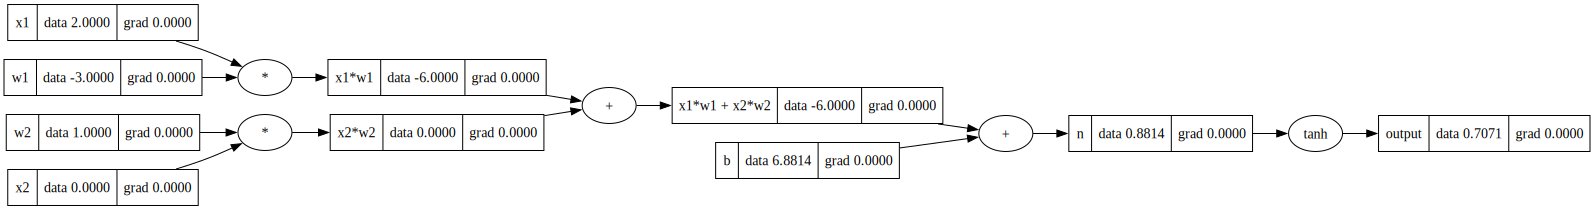

In [87]:
# So now, 

# let's reset the graph:

# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"

draw_dot(output)


In [88]:
output.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)

        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(output)


for node in reversed(topo):
    node._backward()


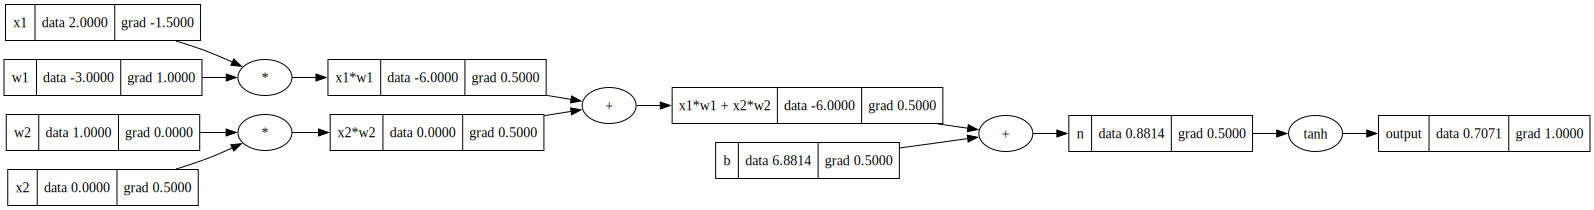

In [89]:
draw_dot(output)


So now let's hide this in the Value class


In [90]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


#### Redefine


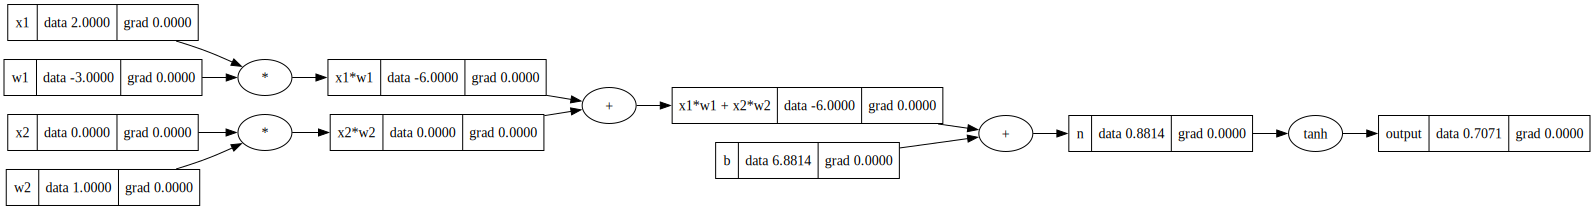

In [91]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"

draw_dot(output)


In [92]:
output.backward()


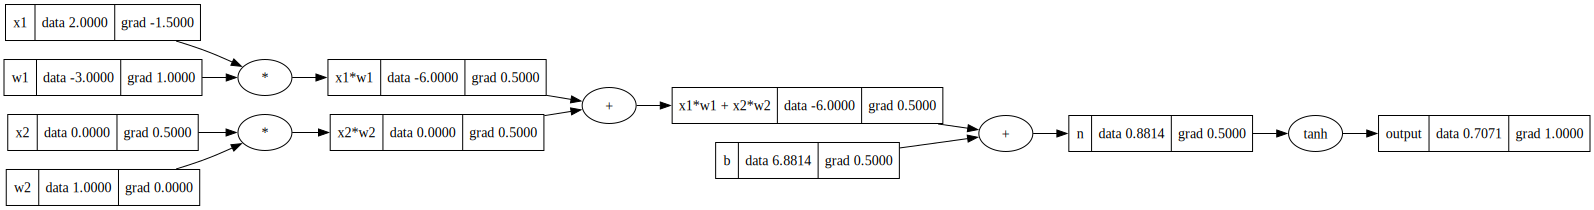

In [93]:
draw_dot(output)


## But wait, there is an error!

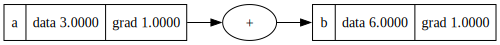

In [94]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


This is wrong, because `b=2a` and db/da should be `2` but `1` is reflected.

This is happening because the gradient is being overwritten.

```
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad
        
        out._backward = backward
        
        return out
```

So here `out` is `b`; And when we do `b._backward()` basically what's happening is `a.grad=1` and `a.grad=1`; `1` is being assigned to `a.grad` twice or it's being overwritten as both `self` and `other` represent the same `Value` object of `a`.


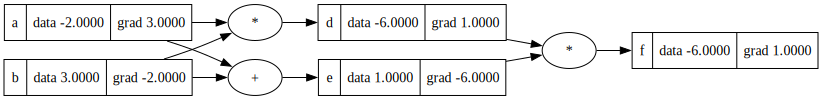

In [96]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)


Problem is that when the same variable is being used twice, the gradient value is being overwritten.
So first a and b's gradient is being calculated as `-6.0` according to the `e` node that "distributes".

But then the `d` node is coming and overwriting the thing...


In [97]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


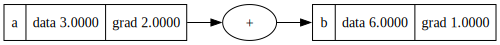

In [98]:
# Redefine:

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


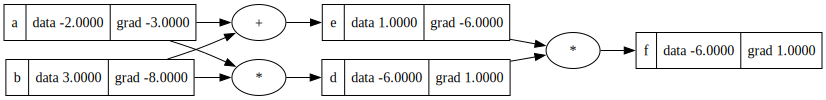

In [99]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)


# So this works perfectly now. The gradients just accumulate on top of each-other.


# Making it more realistic and better

In [101]:
# So,

a = Value(2.0)
a + 1


AttributeError: 'int' object has no attribute 'data'

This fails because 1 is an integer so `other` is 1 and `1.data` does not mean anything.


In [102]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [103]:
# So,

a = Value(2.0)
a + 1


Value(data=3.0)

In [104]:
a = Value(2.0)
a * 8


Value(data=16.0)

In [105]:
# But, 8 * a will not work

8 * a


TypeError: unsupported operand type(s) for *: 'int' and 'Value'

So we need to define `rmul`

Under the hood,

a * 8 --> a.__mul__(8)

and 

8 * a --> 8.__mul__(a)

But that will obviously fail


In [110]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [111]:
# But, 8 * a will not work
a = Value(2.0)
8 * a


Value(data=16.0)

In [112]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        
        out._backward = _backward
    
        return out
    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [113]:
a = Value(2.0)
a.exp()


Value(data=7.38905609893065)

In [114]:
# Now let's do division

a = Value(2.0)
b = Value(4.0)

a/b



TypeError: unsupported operand type(s) for /: 'Value' and 'Value'

In [115]:
# a/b
# a * (1/b)
# a * b**(-1)


# So let's implement x**k for some constant k; Then division will be a special case with k=-1


In [116]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out


    

    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        
        out._backward = _backward
    
        return out
    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [117]:
# Now let's do division

a = Value(2.0)
b = Value(4.0)

a/b



Value(data=0.5)

In [118]:
# Now let's do division

a = Value(2.0)
b = Value(4.0)

a - b



TypeError: unsupported operand type(s) for -: 'Value' and 'Value'

In [142]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out
    

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out


    

    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    def __radd__(self, other):  # other + self
        return self + other
    
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        
        out._backward = _backward
    
        return out
    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [143]:
# Now let's do division

a = Value(2.0)
b = Value(4.0)

a - b



Value(data=-2.0)

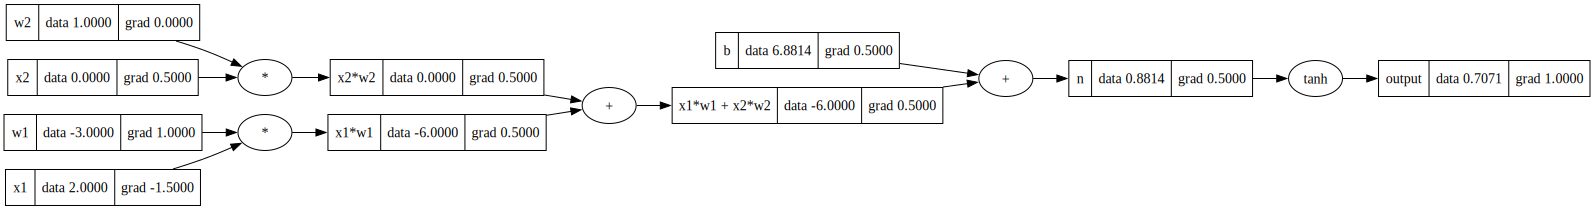

In [144]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"
output.backward()
draw_dot(output)


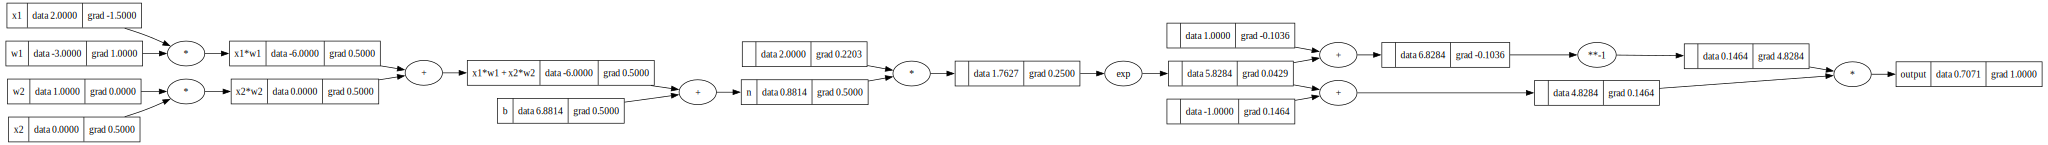

In [145]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# -----
# output = n.tanh(); output.label = "output" # old way to do it; we will break it up now


e = (2*n).exp()
output = (e - 1) / (e + 1)
output.label = 'output'

# -------


output.backward()
draw_dot(output)


In [146]:
import torch


In [147]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


#### So our micrograd is really similar to the PyTorch API except for the fact that in PyTorch everything happens in arrays of numbers not single scaler values (like in our case), so it's much more efficient.


Le'ts now model a neural network

In [148]:
# class Value:

#     def __init__(self, data, _children=(), _op="", label=""):
#         self.data = data
#         self.grad = 0.0
#         self._backward = lambda: None
#         self._prev = set(_children)
#         self._op = _op
#         self.label = label

#     def __repr__(self):
#         return f"Value(data={self.data})"

#     def __add__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data + other.data, (self, other), "+")

#         def _backward():
#             self.grad += 1.0 * out.grad
#             other.grad += 1.0 * out.grad

#         out._backward = _backward

#         return out

#     def __mul__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data * other.data, (self, other), "*")

#         def _backward():
#             self.grad += other.data * out.grad
#             other.grad += self.data * out.grad

#         out._backward = _backward

#         return out

#     def __pow__(self, other):
#         assert isinstance(
#             other, (int, float)
#         ), "only supporting int/float powers for now"
#         out = Value(self.data**other, (self,), f"**{other}")

#         def _backward():
#             self.grad += other * (self.data ** (other - 1)) * out.grad

#         out._backward = _backward

#         return out

#     def __rmul__(self, other):  # other * self
#         return self * other

#     def __truediv__(self, other):  # self / other
#         return self * other**-1

#     def __neg__(self):  # -self
#         return self * -1

#     def __sub__(self, other):  # self - other
#         return self + (-other)

#     def __radd__(self, other):  # other + self
#         return self + other

#     def tanh(self):
#         x = self.data
#         t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
#         out = Value(t, (self,), "tanh")

#         def _backward():
#             self.grad += (1 - t**2) * out.grad

#         out._backward = _backward

#         return out

#     def exp(self):
#         x = self.data
#         out = Value(math.exp(x), (self,), "exp")

#         def _backward():
#             self.grad += (
#                 out.data * out.grad
#             )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

#         out._backward = _backward

#         return out

#     def backward(self):

#         topo = []
#         visited = set()

#         def build_topo(v):
#             if v not in visited:
#                 visited.add(v)
#                 for child in v._prev:
#                     build_topo(child)
#                 topo.append(v)

#         build_topo(self)

#         self.grad = 1.0
#         for node in reversed(topo):
#             node._backward()


In [149]:
import random


In [150]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x [dot product] + b 
        
        return 0.0


x = [2.0, 3.0]
n = Neuron(2)
n(x)  # --> this () notation initates the __call__ function


0.0

In [151]:
#  to illustrate how zip works
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x [dot product] + b 
        
        print(list(zip(self.w, x)))


        return 0.0

x = [2.0, 3.0]
n = Neuron(2)
n(x) 


[(Value(data=-0.9662167339642214), 2.0), (Value(data=-0.7417718515776794), 3.0)]


0.0

In [ ]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...
        out = act.tanh()

        return out


x = [2.0, 3.0]
n = Neuron(2)
n(x)



Value(data=0.3903238110477658)

In [156]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...
        out = act.tanh()

        return out


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


x = [2.0, 3.0]
n = Layer(2,3)
n(x)



[Value(data=0.996846618700116),
 Value(data=-0.9959682606015995),
 Value(data=-0.6382862867461611)]

Let's reimplement this

<img src="./neural_net2.jpeg" width="40%">


In [158]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...
        out = act.tanh()

        return out


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 , 1])
n(x)


Value(data=0.6671956484275877)

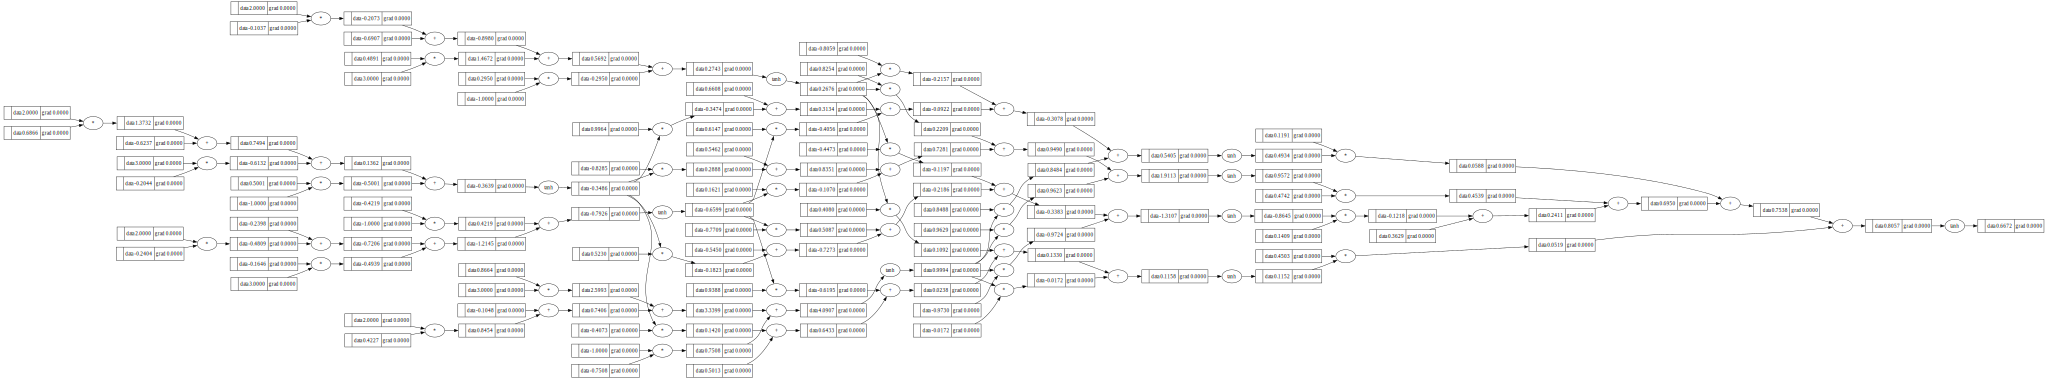

In [ ]:
draw_dot(n(x))


In [161]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred


[Value(data=0.6671956484275877),
 Value(data=-0.14095097052655128),
 Value(data=0.5149301403056871),
 Value(data=0.7122318847339097)]

In [162]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]


[Value(data=0.1107587364255338),
 Value(data=0.7379652350392742),
 Value(data=2.295013330006609),
 Value(data=0.08281048816379781)]

In [165]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=3.226547789635215)

In [ ]:
loss.backward()


In [167]:
n.layers[0].neurons[0].w[0]


Value(data=0.6865844252925253)

In [168]:
n.layers[0].neurons[0].w[0].grad


-0.2621048993917329

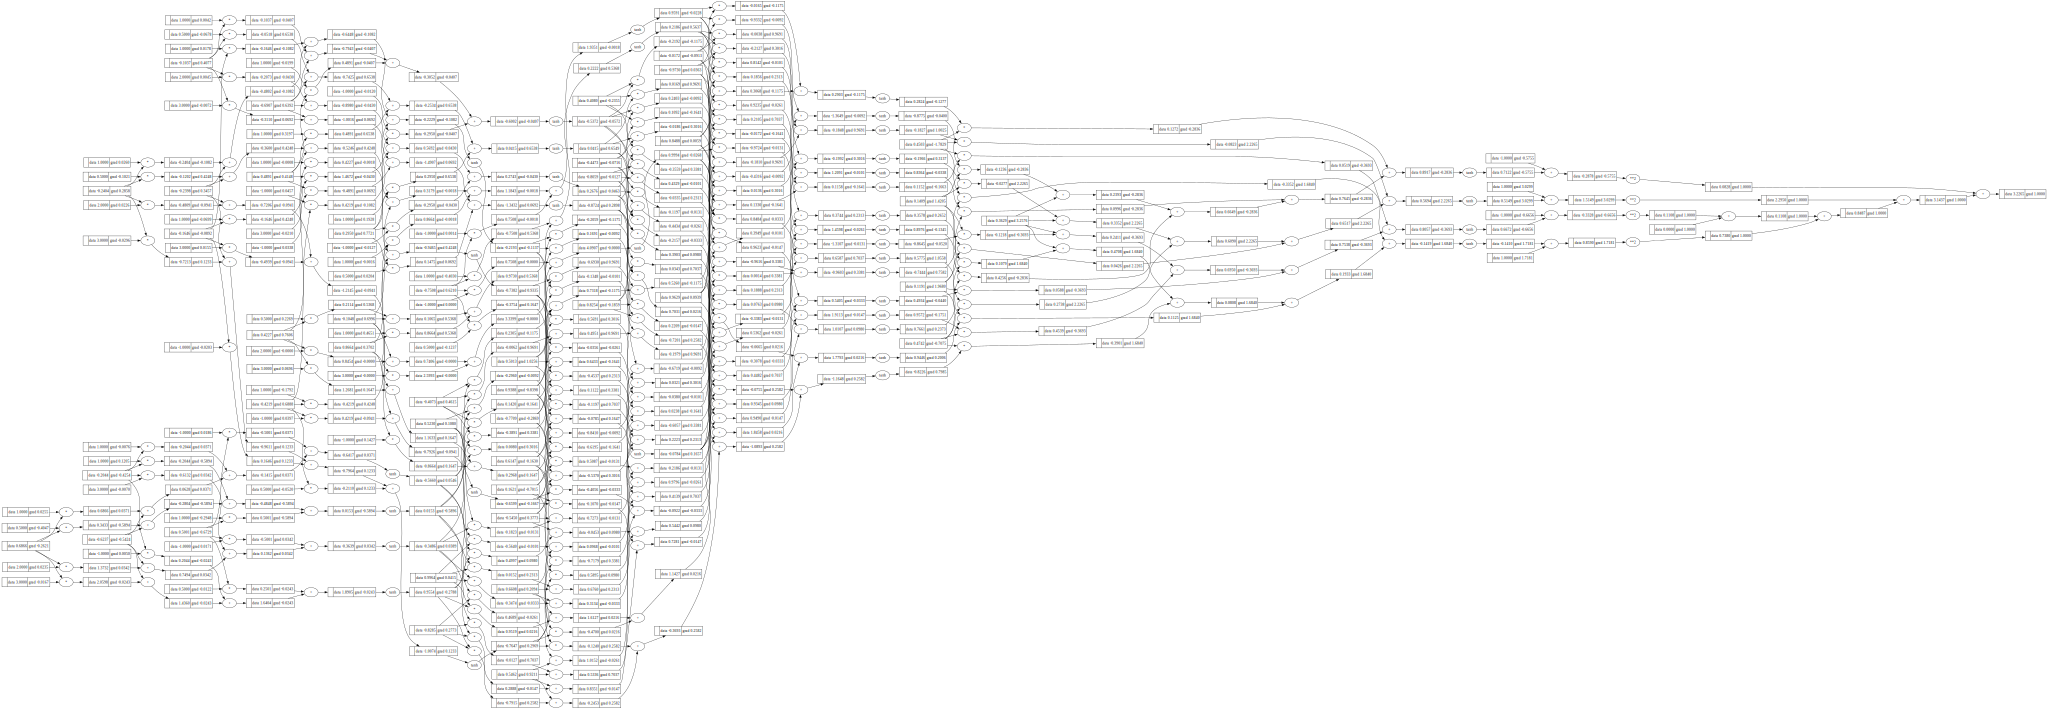

In [169]:
draw_dot(loss)


In [177]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 , 1])
n(x)


Value(data=-0.7448109631160671)

In [178]:
n.parameters()


[Value(data=-0.06139009145007224),
 Value(data=0.7295659380000106),
 Value(data=0.5008073459265434),
 Value(data=-0.497774322575838),
 Value(data=-0.12721560081249006),
 Value(data=-0.2743445706348404),
 Value(data=0.5725430303043919),
 Value(data=-0.15107563035273497),
 Value(data=-0.6763443945715659),
 Value(data=-0.5342463044743453),
 Value(data=0.47490275497106693),
 Value(data=0.3777950147388134),
 Value(data=-0.5112897997665802),
 Value(data=0.035054733473425914),
 Value(data=0.3168670170338952),
 Value(data=0.23215672853707003),
 Value(data=0.19973945874651378),
 Value(data=0.5503029935839545),
 Value(data=0.8385508087822231),
 Value(data=0.361701969695027),
 Value(data=0.9278270077700694),
 Value(data=-0.04588842876915167),
 Value(data=0.7564520209460197),
 Value(data=-0.9584509373770314),
 Value(data=0.9844924590230375),
 Value(data=0.7147396027185764),
 Value(data=-0.20404936712601685),
 Value(data=0.44981364692710857),
 Value(data=0.0872051799100022),
 Value(data=0.938771628

In [179]:
len(n.parameters())


41

In [180]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred


[Value(data=-0.7448109631160671),
 Value(data=-0.9013093255620311),
 Value(data=-0.8782629332508713),
 Value(data=-0.8615929289745689)]

In [181]:

[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]


[Value(data=3.0443652970100175),
 Value(data=0.00973984922102116),
 Value(data=0.014819913420681806),
 Value(data=3.4655282332081137)]

In [182]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=6.534453292859834)

In [183]:
loss.backward()


In [ ]:
n.layers[0].neurons[0].w[0]


Value(data=-0.06139009145007224)

In [185]:
n.layers[0].neurons[0].w[0].grad


-0.33425248782425643

In [186]:
n.layers[0].neurons[0].w[0].data


-0.06139009145007224

In [187]:
for p in n.parameters():
    p.data += -0.01 * p.grad


In [ ]:
n.layers[0].neurons[0].w[0].data


-0.058047566571829676

In [189]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=6.102688992950713)

In [ ]:
# so now gradient descent manually:


In [212]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=0.0026045014408421973)

In [213]:
loss.backward()


In [211]:
for p in n.parameters():
    p.data += -0.1 * p.grad


In [214]:
ypred


[Value(data=0.9927079751356275),
 Value(data=-0.9994491056472474),
 Value(data=-0.9998417130061829),
 Value(data=0.9494925819818587)]

In [ ]:
n.parameters()


[Value(data=0.13683435623626386),
 Value(data=1.2962774257901293),
 Value(data=0.13256465595973163),
 Value(data=-0.3386749944702389),
 Value(data=3.4171464276536083),
 Value(data=-1.761125276675692),
 Value(data=2.2272199952671636),
 Value(data=1.1675889533124035),
 Value(data=-0.9132470300991596),
 Value(data=-0.25548764195686374),
 Value(data=-0.03971079705743008),
 Value(data=0.3398101661427804),
 Value(data=-0.8257184727267277),
 Value(data=-1.7321910185786935),
 Value(data=2.3372462711778272),
 Value(data=-0.05134573625719917),
 Value(data=-0.25402528153597703),
 Value(data=1.1271641923053157),
 Value(data=0.9039347714954238),
 Value(data=0.2861427230427146),
 Value(data=1.0192851459028809),
 Value(data=-1.5281746667570406),
 Value(data=3.6195797475604348),
 Value(data=0.9775670823485689),
 Value(data=2.1830937058692),
 Value(data=-0.733882963411451),
 Value(data=-0.33217784643332093),
 Value(data=0.6367393999557012),
 Value(data=-0.09320194034421317),
 Value(data=0.7274777047029

So let's make this a loop


In [216]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [ ]:
# BUT THERE IS A BUG

for k in range(10):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # loss

    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    
    print(k, loss.data)


0 0.0026045014408421973
1 0.4801929423401987
2 0.00016231569103375738
3 1.5691642860498046e-08
4 1.916927828090354e-07
5 0.0001781314560344623
6 0.3733922409985488
7 8.499006906905349e-16
8 1.3047713639662037e-16
9 5.4690564355262976e-14


In [218]:
ypred


[Value(data=0.9999999999999997),
 Value(data=-0.999999999347116),
 Value(data=-0.9999999999992631),
 Value(data=0.9999997661407729)]

#### so you need to flush out the grad post every epoch, else it stays in there!


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 , 1])
n(x)


Value(data=-0.9692633890175278)

In [222]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [223]:

for k in range(30):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # loss


    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    
    print(k, loss.data)


0 7.7524704910441615
1 7.656207307174241
2 7.457636893075834
3 6.919088382032468
4 4.834465708785091
5 1.776855041817999
6 1.3297286458479278
7 0.9587299889983256
8 0.6749631388372139
9 0.48226407247999514
10 0.35914311857383946
11 0.2785542503575923
12 0.22361760067768297
13 0.1846777118320952
14 0.15606271876573313
15 0.13436524208224526
16 0.11746772503633071
17 0.10400660937744466
18 0.09307399044223283
19 0.08404676515351786
20 0.07648558784374289
21 0.07007316838945074
22 0.06457544177541674
23 0.059816443918401685
24 0.055661639666993584
25 0.05200660277742563
26 0.048769168146535966
27 0.04588388741719784
28 0.043298043936403435
29 0.04096874319521198


In [ ]:
ypred


[Value(data=0.9213668115516249),
 Value(data=-0.9484888681040042),
 Value(data=-0.8696851580858718),
 Value(data=0.876913810127442)]